Data Quality Pipeline (Autoencoder)

This notebook walks through step-by-step EDA, preprocessing, autoencoder training and data-quality risk scoring for the JM1 dataset.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
FEATURE_COLS = [
    "loc",
    "v(g)",
    "ev(g)",
    "iv(g)",
    "n",
    "v",
    "l",
    "d",
    "i",
    "e",
    "b",
    "t",
    "IOCode",
    "IOComment",
    "IOBlank",
    "locCodeAndComment",
    "uniq_Op",
    "uniq_Opnd",
    "total_Op",
    "total_Opnd",
    "branchCount"
]
DEFAULT_TARGET = "defects"
JM1_METRIC_NAMES = {
    # ----- Basic Size Metrics -----
    "loc": "Lines of Code (LOC)",
    "locCodeAndComment": "Lines of Code + Comments",

    # ----- Cyclomatic Complexity -----
    "v(g)": "Cyclomatic Complexity",
    "ev(g)": "Essential Cyclomatic Complexity",
    "iv(g)": "Design Cyclomatic Complexity",

    # ----- Halstead Metrics -----
    "n": "Halstead Total Operands",
    "v": "Halstead Volume",
    "l": "Halstead Program Length Ratio",
    "d": "Halstead Difficulty",
    "i": "Halstead Intelligence / Content",
    "e": "Halstead Effort",
    "b": "Halstead Estimated Bugs",
    "t": "Halstead Time to Implement",

    # ----- Halstead Operators/Operands -----
    "uniq_Op": "Unique Operators",
    "uniq_Opnd": "Unique Operands",
    "total_Op": "Total Operators",
    "total_Opnd": "Total Operands",

    # ----- Structural Metrics -----
    "branchCount": "Number of Branches in Code",

    # ----- I/O Related Metrics (if present) -----
    "IOCode": "Input/Output Code Count",
    "IOComment": "Input/Output Comment Count",
    "IOBlank": "Input/Output Blank Lines",

    # ----- Target -----
    "defects": "Defect Label (0 = Clean, 1 = Defective)"
}


In [4]:
#Hyper-parameters
batch_size = 32
epochs = 40
learning_rate = 0.001
latent_dim = 8 #specifies the size of the compressed feature vector (bottleneck) in an autoencoder
early_stopping_patience = 6 #number of epochs with no improvement after which training will be stopped

In [ ]:
OUT_DIR = '../results'
os.makedirs(OUT_DIR, exist_ok=True)

In [6]:
#Loading the dataset
df = pd.read_csv("../data/data_defects_dataset.csv")


In [7]:
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17.0,36.0,112.0,86.0,13.0,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17.0,135.0,329.0,271.0,5.0,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11.0,16.0,76.0,50.0,7.0,True


In [8]:
df

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17.0,36.0,112.0,86.0,13.0,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17.0,135.0,329.0,271.0,5.0,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11.0,16.0,76.0,50.0,7.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13199,18.0,4.0,1.0,4.0,52.0,241.48,0.14,7.33,32.93,1770.86,...,13,0,2,0,10.0,15.0,30.0,22.0,7.0,False
13200,9.0,2.0,1.0,2.0,30.0,129.66,0.12,8.25,15.72,1069.68,...,5,0,2,0,12.0,8.0,19.0,11.0,3.0,False
13201,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,...,29,1,10,0,18.0,15.0,59.0,44.0,7.0,False
13202,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,...,6,0,2,0,9.0,8.0,21.0,15.0,1.0,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13204 entries, 0 to 13203
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                13204 non-null  float64
 1   v(g)               13204 non-null  float64
 2   ev(g)              13204 non-null  float64
 3   iv(g)              13204 non-null  float64
 4   n                  13204 non-null  float64
 5   v                  13204 non-null  float64
 6   l                  13204 non-null  float64
 7   d                  13204 non-null  float64
 8   i                  13204 non-null  float64
 9   e                  13204 non-null  float64
 10  b                  13204 non-null  float64
 11  t                  13204 non-null  float64
 12  lOCode             13204 non-null  int64  
 13  lOComment          13204 non-null  int64  
 14  lOBlank            13204 non-null  int64  
 15  locCodeAndComment  13204 non-null  int64  
 16  uniq_Op            132

In [10]:
print("\n--- Missing Values Count ---")
print(df.isnull().sum())


--- Missing Values Count ---
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


In [11]:
# Sanitize target column to ensure 0/1 ints

def sanitize_target_col(df, col='defects'):
    if col not in df.columns:
        raise ValueError(f"Target column '{col}' not found in DataFrame")
    s = df[col]
    # Convert booleans
    if s.dtype == bool:
        return df.assign(**{col: s.astype(int)})
    # Try numeric conversion
    try:
        num = pd.to_numeric(s)
        unique = set(num.dropna().unique())
        if unique.issubset({0,1}):
            return df.assign(**{col: num.astype(int)})
    except Exception:
        pass
    # Map common string representations
    def map_bool(x):
        if pd.isna(x):
            return np.nan
        st = str(x).strip().lower()
        if st in {'true','t','1','yes','y'}:
            return 1
        if st in {'false','f','0','no','n'}:
            return 0
        try:
            return int(float(st))
        except Exception:
            return np.nan
    return df.assign(**{col: s.apply(map_bool)})

df = sanitize_target_col(df, DEFAULT_TARGET)
df[DEFAULT_TARGET].value_counts(dropna=False)


defects
0    11101
1     2103
Name: count, dtype: int64

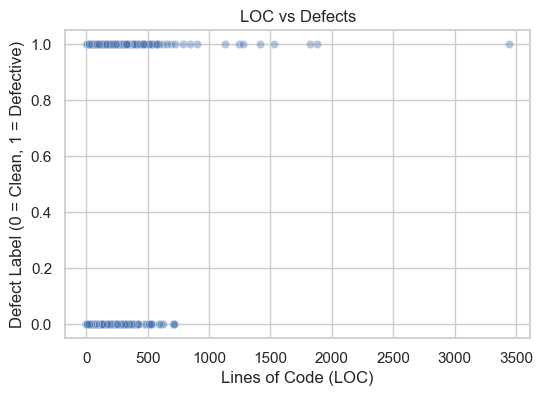

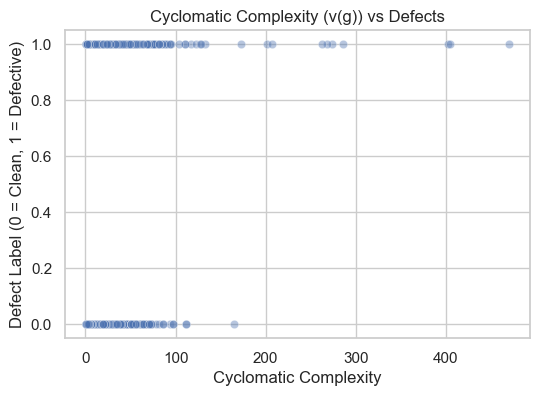

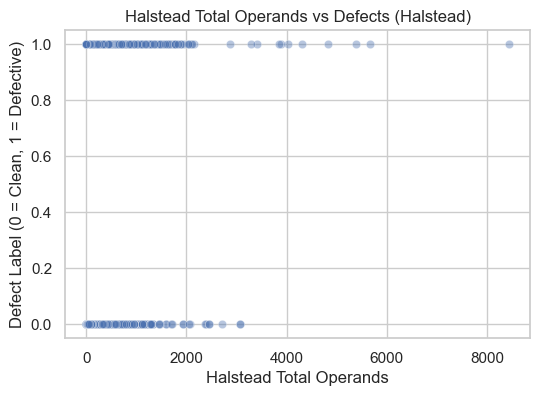

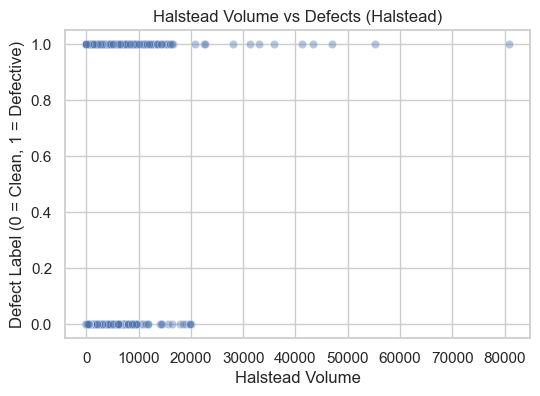

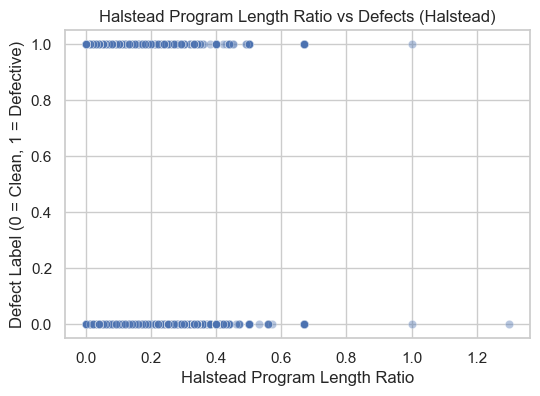

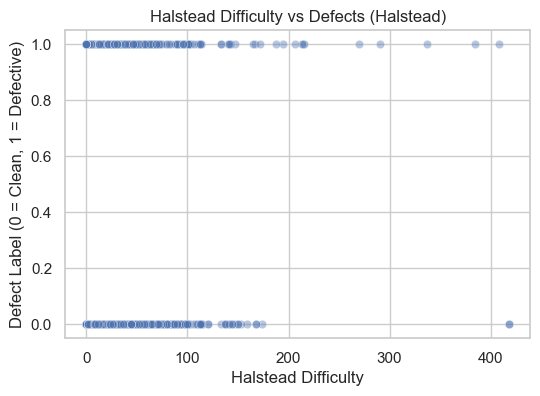

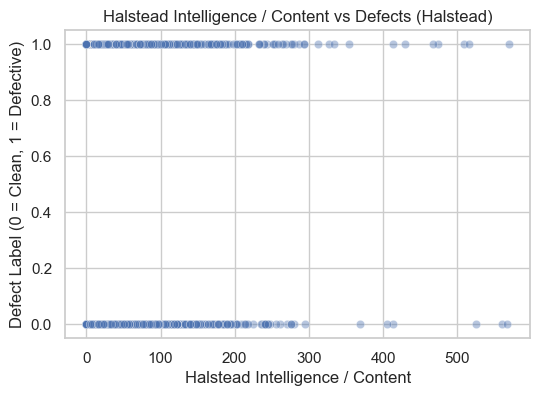

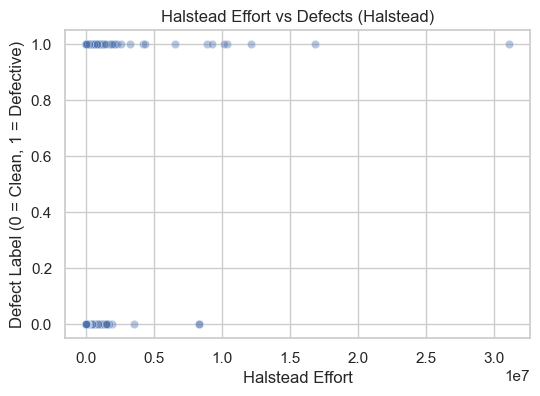

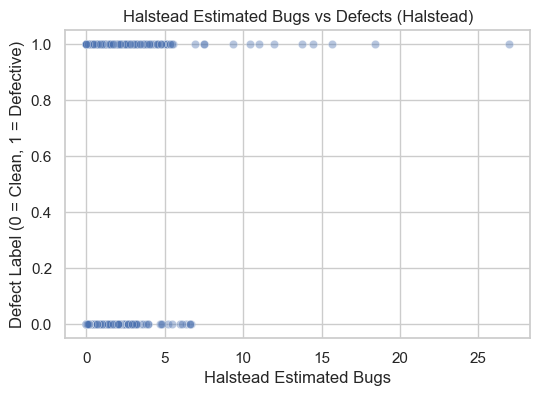

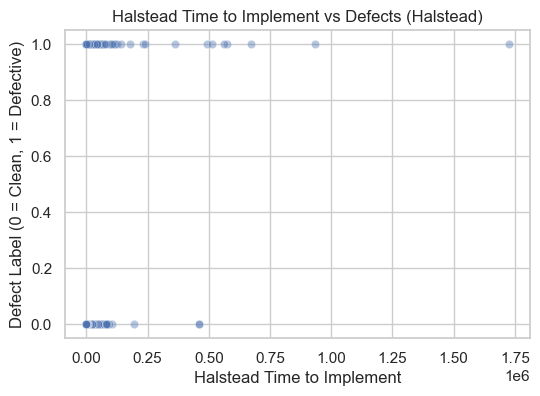

In [12]:
# Pairwise Plots: LOC, Cyclomatic Complexity, Halstead Metrics vs defects

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def label(col):
    return JM1_METRIC_NAMES.get(col, col)

# 1) LOC vs defects
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="loc", y="defects", alpha=0.4)
plt.xlabel(label("loc"))
plt.ylabel(label("defects"))
plt.title("LOC vs Defects")
plt.show()

# 2) Cyclomatic Complexity vs defects  (v(g))
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="v(g)", y="defects", alpha=0.4)
plt.xlabel(label("v(g)"))
plt.ylabel(label("defects"))
plt.title("Cyclomatic Complexity (v(g)) vs Defects")
plt.show()

# 3) Halstead Metrics vs defects
halstead_cols = ["n","v","l","d","i","e","b","t"]  # effort = e, time = t, bugs = b

for col in halstead_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y="defects", alpha=0.4)
    plt.xlabel(label(col))
    plt.ylabel(label("defects"))
    plt.title(f"{label(col)} vs Defects (Halstead)")
    plt.show()


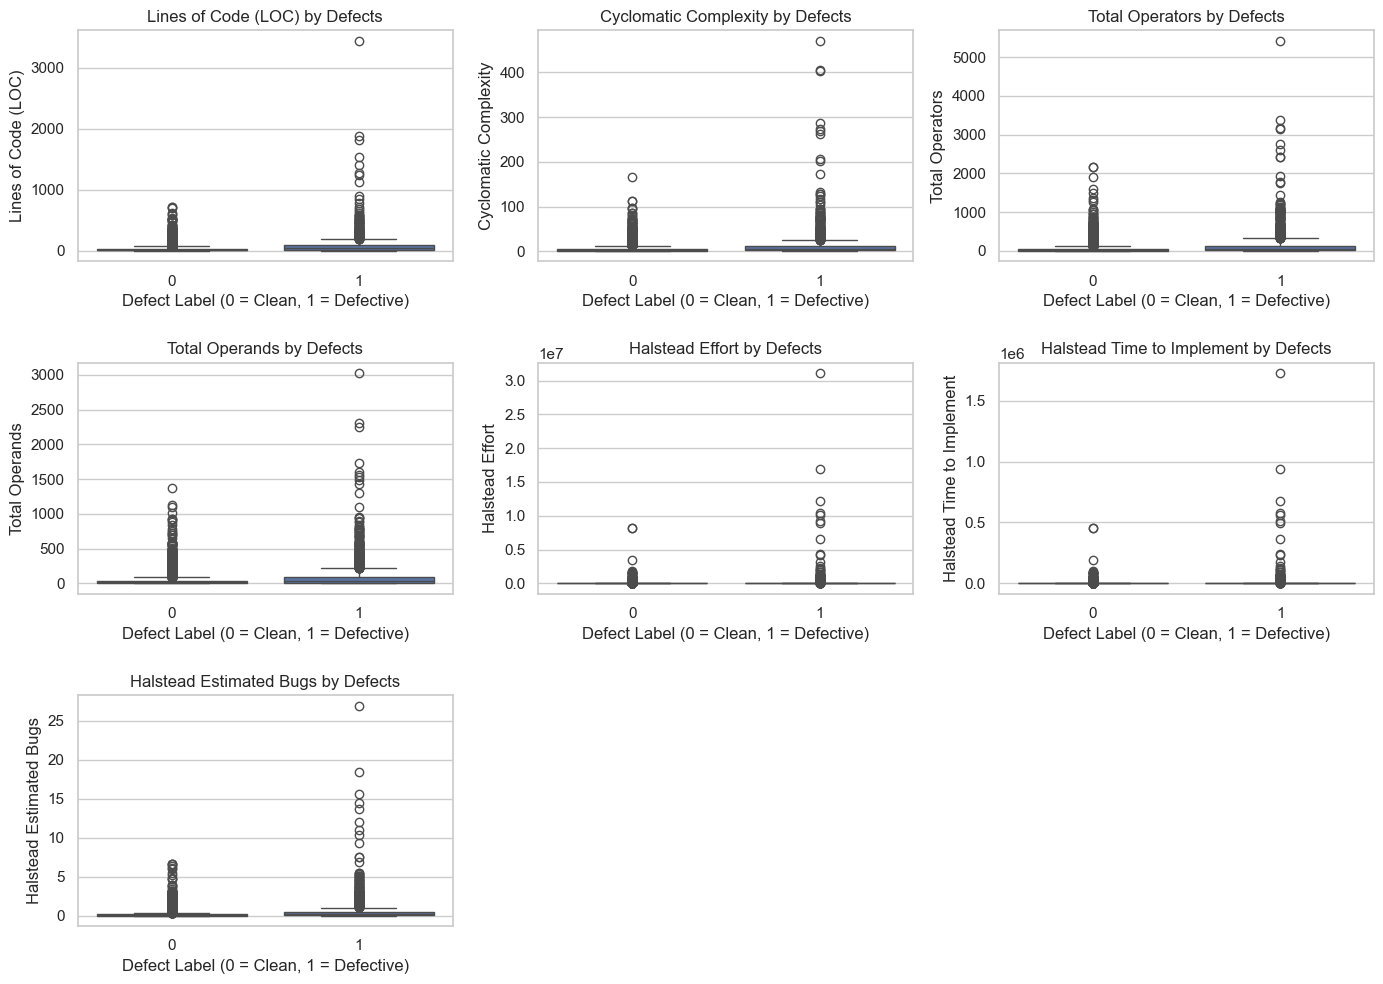

In [13]:
# Boxplots for defective vs non-defective

boxplot_cols = [
    "loc",
    "v(g)",
    "total_Op",
    "total_Opnd",
    "e",   # Halstead effort
    "t",   # Halstead time
    "b"    # Halstead bugs
]

plt.figure(figsize=(14,10))

for i, col in enumerate(boxplot_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x="defects", y=col)
    plt.xlabel(label("defects"))
    plt.ylabel(label(col))
    plt.title(f"{label(col)} by Defects")

plt.tight_layout()
plt.show()


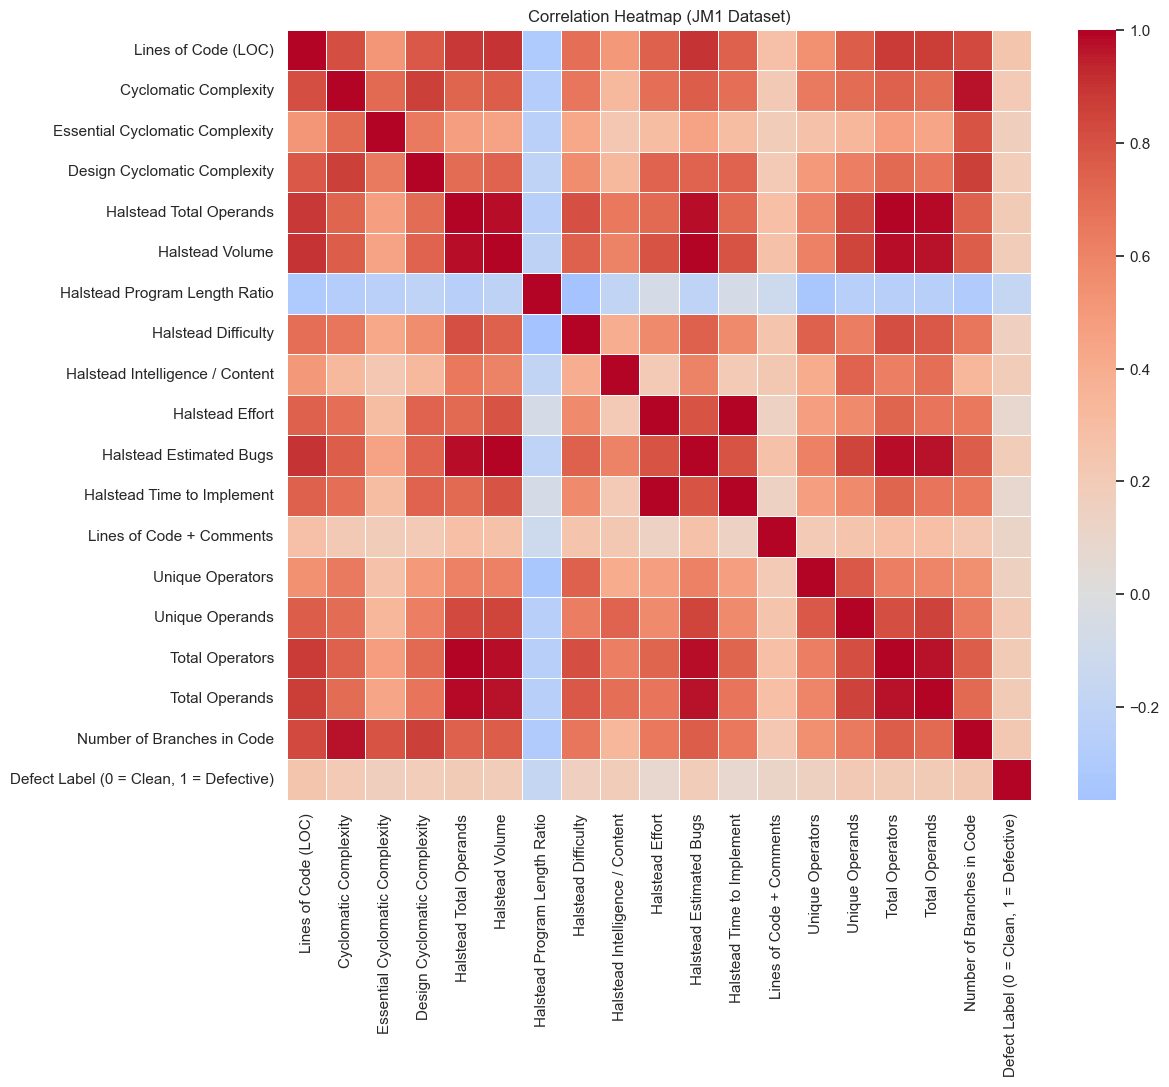

In [14]:
# Correlation Heatmap for JM1 Metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12,10))

features = [c for c in FEATURE_COLS if c in df.columns]

corr = df[features + ["defects"]].corr()

sns.heatmap(
    corr,
    annot=False,       # set to True if you want numbers printed
    cmap="coolwarm",
    linewidths=0.5,
    center=0,
    xticklabels=[JM1_METRIC_NAMES.get(col, col) for col in corr.columns],
    yticklabels=[JM1_METRIC_NAMES.get(col, col) for col in corr.index]
)

plt.title("Correlation Heatmap (JM1 Dataset)")
plt.show()


In [15]:
# ----- Select Features & Scale -----

# Make sure we only use features that actually exist in the dataframe
usable_features = [c for c in FEATURE_COLS if c in df.columns]
print("Using feature columns:", usable_features)

X = df[usable_features].copy()
y = df[DEFAULT_TARGET].copy()    # not used in training, only for analysis

# Fill missing values
X = X.fillna(X.median())

# Standard scaling for AE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)


Using feature columns: ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
Scaled shape: (13204, 18)


In [16]:
# ----- Train AE on only non-defective modules -----
clean_mask = (y == 0)
X_clean = X_scaled[clean_mask]

print("Clean samples:", X_clean.shape[0])

# Train/validation split
X_train, X_val = train_test_split(
    X_clean, test_size=0.2, random_state=RANDOM_SEED
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Clean samples: 11101
Train shape: (8880, 18)
Validation shape: (2221, 18)


In [17]:
# ----- Autoencoder Model -----

input_dim = X_train.shape[1]

inputs = tf.keras.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation="relu")(inputs)
encoded = layers.Dense(16, activation="relu")(encoded)
encoded = layers.Dense(latent_dim, activation="relu")(encoded)

decoded = layers.Dense(16, activation="relu")(encoded)
decoded = layers.Dense(32, activation="relu")(decoded)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = tf.keras.Model(inputs, decoded)

autoencoder.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="mse"
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,554 (9.98 KB)

 Trainable params: 2,554 (9.98 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# ----- Training with Early Stopping -----

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=early_stopping_patience,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)


Epoch 1/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2020 - val_loss: 0.1016
Epoch 2/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0746 - val_loss: 0.0639
Epoch 3/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0464 - val_loss: 0.0393
Epoch 4/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0329 - val_loss: 0.0323
Epoch 5/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0283 - val_loss: 0.0282
Epoch 6/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0256 - val_loss: 0.0256
Epoch 7/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0237 - val_loss: 0.0238
Epoch 8/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - val_loss: 0.0223
Epoch 9/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0206 - val_loss: 0.0220
Epoch 10/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - val_loss: 0.0207
Epoch 11/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0187 - val_loss: 0.0195
Epoch 12/40
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

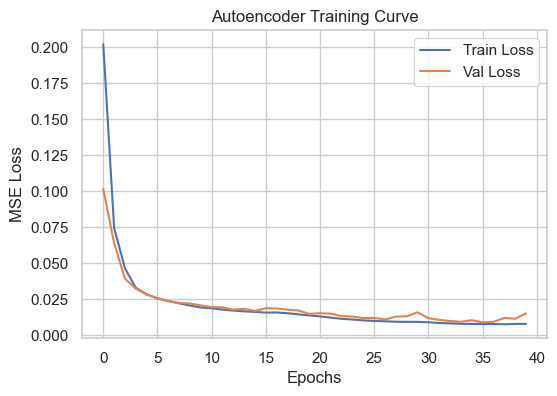

In [19]:
# ----- Plot Training/Validation Loss -----

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Curve")
plt.legend()
plt.show()


In [20]:
# ----- Compute Reconstruction Errors -----

X_recon = autoencoder.predict(X_scaled)
reconstruction_mse = np.mean(np.square(X_scaled - X_recon), axis=1)

df["reconstruction_mse"] = reconstruction_mse

print("Reconstruction error stats:")
df["reconstruction_mse"].describe()


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
Reconstruction error stats:


count    13204.000000
mean         0.049481
std          2.231587
min          0.000203
25%          0.000857
50%          0.001508
75%          0.004419
max        219.108994
Name: reconstruction_mse, dtype: float64

In [21]:
# ----- Normalize MSE into a 0–1 risk score -----

# Use only clean modules to estimate "normal" error distribution
clean_mse = df.loc[y == 0, "reconstruction_mse"]

p95 = np.percentile(clean_mse, 95)
print("95th percentile (clean):", p95)

def normalize_mse(e):
    return min(1.0, max(0.0, e / (p95 + 1e-12)))

df["data_risk_score"] = df["reconstruction_mse"].apply(normalize_mse)

df[["reconstruction_mse", "data_risk_score"]].head()


95th percentile (clean): 0.028084588566949162


,reconstruction_mse,data_risk_score
0,0.639581,1.000000
1,0.248744,1.000000
2,0.001752,0.062394
3,0.093730,1.000000
4,0.000637,0.022688


In [22]:
# ----- Save Output -----

output_path = os.path.join(OUT_DIR, "data_risk_scores.csv")
df.to_csv(output_path, index=False)

print("Saved:", output_path)

# show highest-risk modules
df.sort_values("data_risk_score", ascending=False).head(10)


Saved: ../results/data_risk_scores\data_risk_scores.csv


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects,reconstruction_mse,data_risk_score
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,28,2,17.0,135.0,329.0,271.0,5.0,1,0.093730,1.0
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1.0,1.0,1.0,1.0,1.0,1,0.248744,1.0
57,162.0,27.0,23.0,26.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,53.0,1,0.042121,1.0
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,1.2,1.2,1.2,1.2,1.4,0,0.639581,1.0
62,179.0,36.0,27.0,35.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,71.0,1,0.068981,1.0
63,171.0,16.0,1.0,16.0,644.0,4230.99,0.03,34.25,123.53,144911.31,...,24,22,19.0,76.0,370.0,274.0,31.0,1,0.090577,1.0
48,466.0,110.0,95.0,85.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,219.0,1,0.363254,1.0
49,110.0,27.0,14.0,9.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0.0,0.0,0.0,0.0,53.0,1,0.041970,1.0
50,113.0,19.0,18.0,11.0,491.0,3179.59,0.02,45.40,70.04,144343.07,...,12,0,26.0,63.0,271.0,220.0,37.0,1,0.034145,1.0
22,187.0,35.0,26.0,16.0,526.0,3296.33,0.02,42.56,77.45,140300.03,...,16,0,21.0,56.0,299.0,227.0,69.0,1,0.041298,1.0


In [23]:
# Evaluation summary: ROC-AUC, PR-AUC, best F1 threshold, Precision@K
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import numpy as np

assert 'defects' in df.columns and 'data_risk_score' in df.columns

y_true = df['defects'].astype(int).values
y_score = df['data_risk_score'].values

roc = roc_auc_score(y_true, y_score)
prec, rec, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(rec, prec)

best_thr = 0.0
best_f1 = 0.0
for thr in np.linspace(0,1,101):
    preds = (y_score >= thr).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1; best_thr = thr

def precision_at_k(y_true, scores, k):
    idx = np.argsort(scores)[::-1][:k]
    return y_true[idx].sum() / float(k)

p10 = precision_at_k(y_true, y_score, 10) if len(y_score) >= 10 else None
p20 = precision_at_k(y_true, y_score, 20) if len(y_score) >= 20 else None
p50 = precision_at_k(y_true, y_score, 50) if len(y_score) >= 50 else None

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")
print(f"Best F1: {best_f1:.4f} at threshold {best_thr:.2f}")
print(f"Precision@10: {p10 if p10 is not None else 'n/a'}")
print(f"Precision@20: {p20 if p20 is not None else 'n/a'}")
print(f"Precision@50: {p50 if p50 is not None else 'n/a'}")


ROC-AUC: 0.6716
PR-AUC:  0.3271
Best F1: 0.3589 at threshold 0.13
Precision@10: 0.5
Precision@20: 0.45
Precision@50: 0.42


In [24]:
# Show top 10 high-risk modules
display(df.sort_values('data_risk_score', ascending=False).head(10)[['data_risk_score','reconstruction_mse', 'defects']])

,data_risk_score,reconstruction_mse,defects
3,1.0,0.093730,1
1,1.0,0.248744,1
57,1.0,0.042121,1
0,1.0,0.639581,0
62,1.0,0.068981,1
63,1.0,0.090577,1
48,1.0,0.363254,1
49,1.0,0.041970,1
50,1.0,0.034145,1
22,1.0,0.041298,1
